This is a small showcase to show the usage of a LSTM using PyTorch for sequence classification. I didn't found a good time series dataset, so I decided to use mnist but the steps on a time series dataset should be similar.

In [1]:
# Auto reload external libs on file change
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import *
from joblib import dump, load
from sklearn.preprocessing import StandardScaler

# LSTM
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import random

import tensorflow as tf

# Load data
- I didn't found a good time series dataset, so I decided to use mnist
- loads the mnist dataset
- these are images and no (time) sequences but for the basic showcase we can use each picture as an sequence of 28 steps with 28 pixels (features) each

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [3]:
# Make training deterministic
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Check GPU support
if torch.cuda.is_available():
    print('cuda (GPU) availabe')
    device = 'cuda'
else:
    print('Warning: only cpu available. Training is going to need much more time without a GPU')
    device = 'cpu'

cuda (GPU) availabe


# Model definition

In [4]:
# Define our LSTM Model
# Firstly we have to define a class extending the base class for all neural networks: nn.Module
class LSTMClassifier(nn.Module):
    
    # Override needed functions
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # Set initial hidden and cell states 
        #self.h = torch.zeros(self.num_layers, 100, self.hidden_dim)
        #self.c = torch.zeros(self.num_layers, 100, self.hidden_dim)
        
        # Define the LSTM layer(s)
        # The LSTM takes measurements as inputs with a size of input_dim
        # has layer_dim hidden layers
        # and outputs hidden states with dimensionality of hidden_dim
        # batch_first=True -> Input,Output in this format: (batch, seq, feature)
        # otehrwise (seq, feature, batch)
        # seq = complete sequenz, input_t = seq[timestep]
        # feature = input_t[feature]
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=0.25, batch_first=True)
                
        # Define the output layer
        # The linear layer that maps from hidden state to output classes
        self.hidden2target = nn.Linear(hidden_dim, num_classes)
    
    # Defines the computation performed at every call
    def forward(self, x):            
        # Forward propagate LSTM
        out, _ = self.lstm(x) # out: tensor of shape (batch_size, SEQUENCE_LENGTH, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.hidden2target(out[:, -1, :])
        return out

In [5]:
print('Start scaling')
# can't deal with 3d shape - so reshape to 2D and after scaling reshape back to 3D
SEQUENCE_LENGTH = x_train.shape[1]

standard_scaler = StandardScaler()
train = standard_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1]))
test = standard_scaler.transform(x_test.reshape(-1, x_test.shape[-1]))
dump(standard_scaler, 'lstm_scaler.pt')

train = train.reshape(-1, SEQUENCE_LENGTH, train.shape[-1])
test = test.reshape(-1, SEQUENCE_LENGTH, test.shape[-1])

X_train_tensor = torch.from_numpy(train).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)
X_test_tensor = torch.from_numpy(test).type(torch.FloatTensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)

# Pytorch train and test sets
train_ds = torch.utils.data.TensorDataset(X_train_tensor,y_train_tensor)
test_ds = torch.utils.data.TensorDataset(X_test_tensor,y_test_tensor)

# DataLoader
batch_size = 100
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

print('Data preparation done')

Start scaling
Data preparation done


# Init model

In [10]:
# Hyper-parameters
# it seems a lower hidden_dim makes the model more robust
# hidden_dim: 20
LSTM_MODEL_NAME = 'models/best_model_lstm.pth'

input_dim = X_train_tensor.shape[2]
hidden_dim = 20
num_layers = 2
num_classes = 10

# Create the LSTM Model
model = LSTMClassifier(input_dim, hidden_dim, num_layers, num_classes).to(device)
 
# Cross Entropy Loss with class weights
from sklearn.utils import class_weight
vehicles = y_train
weights = class_weight.compute_class_weight('balanced', np.sort(np.unique(vehicles)), vehicles)
loss_function = nn.CrossEntropyLoss(torch.from_numpy(weights).type(torch.FloatTensor).to(device))
#loss_function = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print('Model initialization done')

Model initialization done


In [11]:
start_train = time.time()

num_epochs = 50

train_losses = []
test_losses = []
best_test_loss = np.finfo(np.float).max
best_test_bal_acc = 0
acces = []
iteration = 0

print('Start training...')
for epoch in range(num_epochs):
    # Set model to train mode
    model.train()
    curr_train_loss = 0
    curr_test_loss = 0
    
    # Train
    for train_seqs, labels in train_dl:
        # Move the data to gpu
        train_seqs = train_seqs.to(device)
        labels = labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
                        
        # Forward propagation
        outputs = model(train_seqs) # calls model.forward(X_train)
        
        # Calculate cross entropy loss (log_softmax and nll)
        train_loss = loss_function(outputs, labels)
        curr_train_loss += train_loss.item() * train_seqs.size(0)
                
        # Calculating gradients
        train_loss.backward()
        
        # Update parameters with computed gradients
        optimizer.step()

    # Test
    # Set model to test mode (no gradient calculations)
    model.eval()
    with torch.no_grad():
        # Calculate accuracy for test set
        correct = 0
        total = 0

        test_preds = []
        test_labels = []
        
        # Iterate through test dataset
        for test_seqs, labels in test_dl:
            # Move the data to gpu
            test_seqs = test_seqs.to(device)
            labels = labels.to(device)
        
            # Forward pass only to get logits/output
            outputs = model(test_seqs)

            # Calculate loss
            test_loss = loss_function(outputs, labels)
            curr_test_loss += test_loss.item() * test_seqs.size(0)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()
            test_preds.append(predicted)
            test_labels.append(labels)

        curr_train_loss = curr_train_loss / len(train_dl.dataset)
        curr_test_loss = curr_test_loss / len(test_dl.dataset)
        
        test_accuracy = 100 * correct / total
        train_losses.append(curr_train_loss)
        test_losses.append(curr_test_loss)
        acces.append(test_accuracy)
        test_bal_acc = balanced_accuracy_score(torch.cat(test_labels).cpu(), torch.cat(test_preds).cpu())
    
        # Print epoch loss
        print(f'Epoch {epoch}/{num_epochs-1} ({str(datetime.timedelta(seconds=time.time()- start_train))}) --- Train_Loss: {curr_train_loss :.3f} / Test_Loss: {curr_test_loss:.3f} / Test-Accuracy: {test_accuracy} / Balanced Accuracy: {test_bal_acc:.2f}')
        
        # Save the best model
        if test_bal_acc >= best_test_bal_acc:
            if test_bal_acc == best_test_bal_acc and curr_test_loss > best_test_loss:
                pass
            else:
                print('Found better Model, save it...')
                torch.save(model.state_dict(), LSTM_MODEL_NAME)
                best_test_bal_acc = test_bal_acc
                best_test_loss = curr_test_loss
    
    # Reduce LR after some epochs
    scheduler.step()

# Load the best model for further interactions            
model = LSTMClassifier(input_dim, hidden_dim, num_layers, num_classes).to(device)
model.load_state_dict(torch.load(LSTM_MODEL_NAME))
model.eval()

Start training...
Epoch 0/49 (0:00:04.003825) --- Train_Loss: 0.496 / Test_Loss: 0.181 / Test-Accuracy: 95 / Balanced Accuracy: 0.95
Found better Model, save it...
Epoch 1/49 (0:00:08.142438) --- Train_Loss: 0.182 / Test_Loss: 0.145 / Test-Accuracy: 96 / Balanced Accuracy: 0.96
Found better Model, save it...
Epoch 2/49 (0:00:12.346567) --- Train_Loss: 0.149 / Test_Loss: 0.122 / Test-Accuracy: 96 / Balanced Accuracy: 0.96
Found better Model, save it...
Epoch 3/49 (0:00:16.616767) --- Train_Loss: 0.125 / Test_Loss: 0.110 / Test-Accuracy: 97 / Balanced Accuracy: 0.97
Found better Model, save it...
Epoch 4/49 (0:00:20.943104) --- Train_Loss: 0.112 / Test_Loss: 0.100 / Test-Accuracy: 97 / Balanced Accuracy: 0.97
Found better Model, save it...
Epoch 5/49 (0:00:25.263927) --- Train_Loss: 0.099 / Test_Loss: 0.097 / Test-Accuracy: 97 / Balanced Accuracy: 0.97
Found better Model, save it...
Epoch 6/49 (0:00:29.782642) --- Train_Loss: 0.096 / Test_Loss: 0.094 / Test-Accuracy: 97 / Balanced Accura

LSTMClassifier(
  (lstm): LSTM(28, 20, num_layers=2, batch_first=True, dropout=0.25)
  (hidden2target): Linear(in_features=20, out_features=10, bias=True)
)

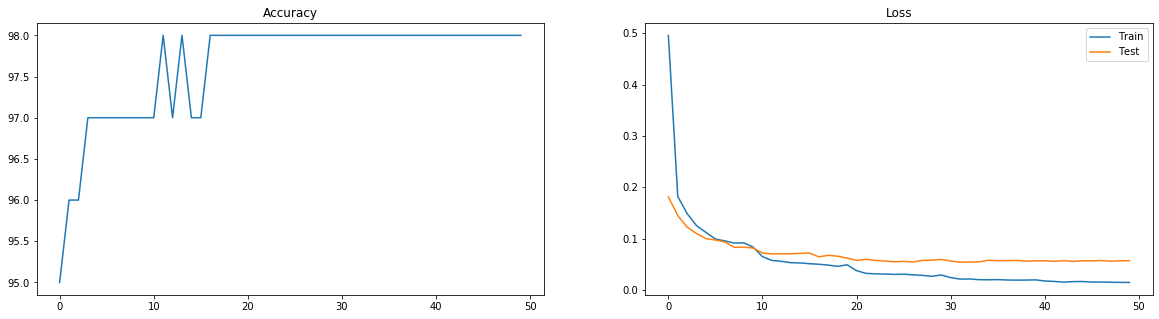

In [12]:
# Plot learning curves
import matplotlib.pyplot as plt
plt.figure(figsize = (20,5))
plt.subplot(1,2, 1)
plt.title('Accuracy')
plt.plot(acces)

plt.subplot(1,2, 2)
plt.title('Loss')
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()

# Validate

In [13]:
model = LSTMClassifier(input_dim, hidden_dim, num_layers, num_classes).to(device)
model.load_state_dict(torch.load(LSTM_MODEL_NAME))
model.eval()

with torch.no_grad():
    predictions = []
    ground_truth = []
    for test_seqs, labels in test_dl:
        test_seqs = test_seqs.to(device)
        labels = labels.to(device)
        
        # Get probabilities of predictions
        outputs = model(test_seqs)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        predictions = np.append(predictions, predicted.cpu().numpy(), axis=0)
        ground_truth = np.append(ground_truth, labels.cpu().numpy(), axis=0)

In [14]:
confusion_matrix(ground_truth, predictions)
print(classification_report(ground_truth, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.98      0.99      0.99      1032
         3.0       0.99      0.99      0.99      1010
         4.0       0.99      0.99      0.99       982
         5.0       0.98      0.99      0.99       892
         6.0       0.98      0.99      0.99       958
         7.0       0.98      0.99      0.99      1028
         8.0       0.98      0.98      0.98       974
         9.0       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [15]:
confusion_matrix(ground_truth, predictions)

array([[ 973,    0,    0,    1,    0,    1,    4,    1,    0,    0],
       [   0, 1128,    1,    0,    0,    0,    2,    0,    4,    0],
       [   1,    1, 1021,    0,    1,    0,    1,    4,    3,    0],
       [   0,    0,    4,  995,    0,    8,    0,    2,    0,    1],
       [   0,    0,    0,    0,  969,    0,    5,    0,    1,    7],
       [   1,    1,    0,    4,    1,  880,    3,    0,    1,    1],
       [   4,    2,    1,    0,    0,    1,  949,    0,    1,    0],
       [   0,    3,    8,    0,    1,    0,    0, 1015,    0,    1],
       [   2,    2,    4,    1,    1,    2,    2,    2,  955,    3],
       [   1,    1,    0,    1,   10,    2,    0,    8,    5,  981]])